In [1]:
import numpy as np
import random
import os
import cv2
import pandas
import matplotlib.pyplot as plt
import imutils
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import KFold
import keras
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix
from numpy import mean
from numpy import std
from keras.datasets import mnist
from PIL import Image, ImageOps

In [2]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Mounted at /content/gdrive


'/device:GPU:0'

In [3]:
location = "/content/gdrive/My Drive/Colab Notebooks/MNIST/"

data_0 = np.load(location + "Data/data0.npy")
data_1 = np.load(location + "Data/data1.npy")
data_2 = np.load(location + "Data/data2.npy")

label_0 = np.load(location + "Label/lab0.npy")
label_1 = np.load(location + "Label/lab1.npy")
label_2 = np.load(location + "Label/lab2.npy")

train_data = np.vstack((data_0, data_1, data_2))
train_lab = np.hstack((label_0, label_1, label_2))
print("Original dataset sizes:", train_data.shape, train_lab.shape)

img_rows = train_data.shape[1]
img_cols = train_data.shape[2]

train_data = train_data.reshape(-1, img_rows, img_cols, 1)
train_data = train_data.reshape(-1, img_rows, img_cols, 1)

print("Reformed dataset sizes:", train_data.shape, train_lab.shape)

Original dataset sizes: (30000, 40, 168) (30000,)
Reformed dataset sizes: (30000, 40, 168, 1) (30000,)


In [4]:
# poisson noise
def poission_noise(dataset):

  vals = len(np.unique(dataset))
  vals = 2 ** np.ceil(np.log2(vals))
  dataset = np.random.poisson(dataset * vals) / float(vals)
  return dataset

# salt and pepper noise
def salt_pepper_noise(dataset, prob = 0.005):
    
    thres = 1 - prob 
    for i in range(dataset.shape[0]):
      for j in range(dataset.shape[1]):
        for x in range(dataset.shape[2]):
          rdn = random.random()
          if rdn < prob:
              dataset[i][j][x] = 0
          elif rdn > thres:
              dataset[i][j][x] = 255
          else:
              dataset[i][j][x] = dataset[i][j][x]
    return dataset

# gaussian noise
def gaussian_noise(dataset, mult=1):

  gauss = np.random.normal(0,1, dataset.size)
  gauss = gauss.reshape(dataset.shape[0],dataset.shape[1],dataset.shape[2]).astype('float32')
  dataset += mult*gauss

  return dataset

# bilateral filter
def bilateral_filter(dataset, num_pix = 15):

  for i in range(dataset.shape[0]):
    image = dataset[i, :, :]
    mean_image = cv2.bilateralFilter(image, num_pix, 75, 75)
    dataset[i, :, :] = mean_image

  return dataset

def check_metrics(model, X_test, y_test):  

  y_pred = np.argmax(model.predict(X_test),axis = 1)
  y_true = np.argmax(y_test, axis=1)
  print('##############  Confusion Matrix  ##############')
  print()
  np.set_printoptions(threshold=np.inf)
  print(confusion_matrix(y_true, y_pred))
  np.set_printoptions(threshold=100)
  print()
  print('##############  Classification Report  ##############')
  print()
  target_names = [str(i) for i in range(10)]
  print(classification_report(y_true, y_pred, target_names=target_names))

def resize_to_fit(image, width, height):
    
    deltaw = width - image.shape[1]
    deltah = height - image.shape[0]
    if (deltaw < 0 or deltah < 0):
      if (deltaw < 0):
        image = image[:, :28]
        deltaw = width - image.shape[1]
      if (deltah < 0):
        image = image[:28, :]
        deltah = height - image.shape[0]
    if (deltaw % 2 == 0):
      padW1 = int(deltaw/2)
      padW2 = padW1
    else:
      padW1 = int(deltaw/2)
      padW2 = padW1 + 1
    if (deltah % 2 == 0):
      padH1 = int(deltah/2)
      padH2 = padH1
    else:
      padH1 = int(deltah/2)
      padH2 = padH1 + 1
    image = cv2.copyMakeBorder(image, padH1, padH2, padW1, padW2, cv2.BORDER_CONSTANT, value=0)
    return image

In [5]:
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# trainX = gaussian_noise(trainX)
# testX = gaussian_noise(testX)

trainX = bilateral_filter(trainX, 5)
testX = bilateral_filter(testX, 5)

trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
trainY = to_categorical(trainY)
testY = to_categorical(testY)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

trainX = trainX.astype('float32')
trainX /= 255.0
 
testX = testX.astype('float32')
testX /= 255.0

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


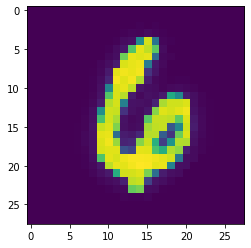

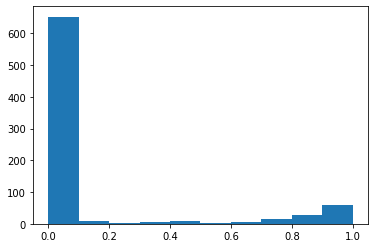

In [6]:
index = 39

plt.imshow(trainX[index].reshape(28,28))
plt.show()
plt.hist(trainX[index].reshape(28, 28).ravel(),10,[0,1])
plt.show()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)              

In [ ]:
batch_size = 200
num_epoch = 1
model_log = model.fit(trainX, trainY, batch_size=batch_size, epochs=num_epoch, verbose=1, validation_data=(testX, testY))

300/300 [==============================] - 2s 7ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0294 - val_accuracy: 0.9930


In [ ]:
choice = int(input("Do you want to store this model?? Enter 1 for Yes and 0 for No: "))
if(choice == 1):
  
  acc_tr = int(input("Enter train accuracy rounded to the nearest integer: "))
  acc_va = int(input("Enter validation accuracy rounded to the nearest integer: "))
  file_name = "/content/gdrive/My Drive/Colab Notebooks/MNIST/" + 'model_' + str(acc_tr) + "_" + str(acc_va)

  # Save the model
  # serialize model to JSON
  model_json = model.to_json()
  with open(file_name + ".json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(file_name +".h5")
  print("Saved model to disk")

Do you want to store this model?? Enter 1 for Yes and 0 for No: 1
Enter train accuracy rounded to the nearest integer: 9995
Enter validation accuracy rounded to the nearest integer: 9930
Saved model to disk


In [11]:
choice = int(input("Do you want to load any saved model? Enter 1 for Yes and 0 for No: "))
if(choice == 1):

  acc_tr = int(input("Enter train accuracy rounded to the nearest integer: "))
  acc_va = int(input("Enter validation accuracy rounded to the nearest integer: "))
  file_name = "/content/gdrive/My Drive/Colab Notebooks/MNIST/" + 'model_' + str(acc_tr) + "_" + str(acc_va)

  # load json and create model
  json_file = open(file_name + '.json', 'r')
  model_json = json_file.read()
  json_file.close()
  model = model_from_json(model_json)
  # load weights into new model
  model.load_weights(file_name + ".h5")
  print("Loaded model from disk")

  # evaluate loaded model on test data
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Do you want to load any saved model? Enter 1 for Yes and 0 for No: 1
Enter train accuracy rounded to the nearest integer: 9997
Enter validation accuracy rounded to the nearest integer: 9943
Loaded model from disk


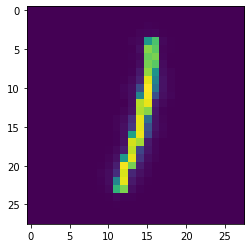

1


In [12]:
index = 3203
plt.imshow(testX[index].reshape(28, 28))
plt.show()
label_p = np.argmax(model.predict(testX[index].reshape(1, 28, 28, 1)))
print(label_p)

<Figure size 432x288 with 0 Axes>

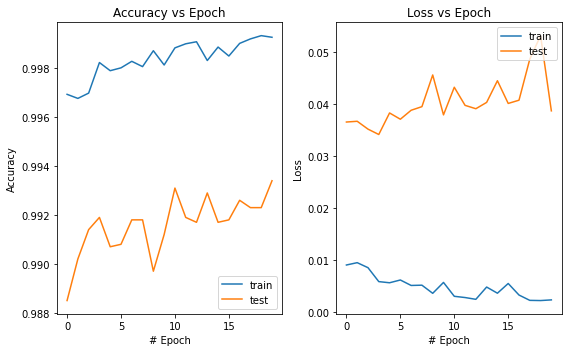

In [ ]:
fig = plt.figure()
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
# plt.savefig(location + "Plots.png")

In [ ]:
check_metrics(model, testX, testY)

##############  Confusion Matrix  ##############

[[ 975    1    0    0    1    0    2    1    0    0]
 [   0 1133    0    1    0    1    0    0    0    0]
 [   0    0 1027    0    0    0    2    3    0    0]
 [   0    0    2 1002    0    5    0    1    0    0]
 [   0    0    0    0  978    0    2    0    0    2]
 [   1    0    0    4    0  881    4    1    1    0]
 [   1    3    0    0    1    1  952    0    0    0]
 [   0    8    2    0    1    0    0 1016    0    1]
 [   4    0    3    1    2    0    0    2  958    4]
 [   0    1    0    0   10    6    1    4    0  987]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99     

In [13]:
bad_image_count = 0
bad_image_dict = dict()

correct = 0
semicorrect = 0
incorrect = 0

show = 0
start = 0
end = 1000


for (i,image) in enumerate(train_data[start:end]):

    if(i>0 and i%100 == 0):
      print(i, correct, semicorrect, incorrect, int(correct/(correct+incorrect+semicorrect)*10000)/100,
            int(semicorrect/(correct+incorrect+semicorrect)*10000)/100,
            int(incorrect/(correct+incorrect+semicorrect)*10000)/100, "Done")
      
    padded_image = cv2.copyMakeBorder(image, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    if(show == 1):
      plt.imshow(padded_image)
      plt.show()
      
    # Finding the contours in the image
    contours = cv2.findContours(padded_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[1] if imutils.is_cv3() else contours[0]
    
    letter_image_regions = []

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        
        if (w > 40):
            # print("Splitting into 3")
            # This contour is too wide to be a single letter, hence split
            onethird_width = int(w / 3)
            letter_image_regions.append((x, y, onethird_width, h))
            letter_image_regions.append((x + onethird_width, y, onethird_width, h))
            letter_image_regions.append((x + 2*onethird_width, y, onethird_width, h))
        
        elif (w > 20):
            # print("Splitting into 2")
            # This contour is too wide to be a single letter, hence split
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        
        elif (w< 3 or h<9):
            # print("Random pixel block")
            # Some error in contouring, ignore!
            continue
        
        else:
            letter_image_regions.append((x, y, w, h))
        
    # If less/more than 4 detected digits take note of the error
    if len(letter_image_regions) != 4:
        bad_image_count+=1
        if (str(len(letter_image_regions)) not in bad_image_dict):
            bad_image_dict[str(len(letter_image_regions))] = [i] 
        else:
            bad_image_dict[str(len(letter_image_regions))].append(i)

    # Sort the detected letter images based on the x coordinate
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    sum = 0

    for letter_bounding_box in letter_image_regions:
        x, y, w, h = letter_bounding_box
        letter_image = padded_image[y-2:y + h+2, x-2:x + w+2]
        modified_image = resize_to_fit(letter_image, 28, 28)
        modified_image = modified_image.astype('float32')

        # gauss = np.random.normal(0,1, modified_image.size)
        # gauss = gauss.reshape(modified_image.shape[0],modified_image.shape[1]).astype('float32')
        # modified_image += gauss

        modified_image = cv2.bilateralFilter(modified_image, 7, 15, 15)

        modified_image /= 255.0
        
        if(show == 1):
          plt.imshow(modified_image)
          plt.show()
          plt.hist(modified_image.ravel(),10,[0,1])
          plt.show()

        model_prediction = np.argmax(model.predict(modified_image.reshape(1, 28, 28, 1)),axis = 1)[0]
        if(show == 1):
          print(model_prediction)
        sum += model_prediction

    if(show == 1):
      print(train_lab[start+i], sum)
    
    if ((train_lab[i+start] - sum) == 0):
      correct +=1
    elif ((train_lab[i+start] - sum) % 5 == 0):
      semicorrect +=1
    else:
      incorrect +=1

print("Correctly classified:", correct)
print("Semi-correctly classified:", semicorrect)
print("Incorrectly classified:", incorrect)
print("Percentage Accuracy:", int(correct/(correct+incorrect+semicorrect)*10000)/100)
print("Percentage Semi-Accuracy:", int(semicorrect/(correct+incorrect+semicorrect)*10000)/100)
print("Percentage Inaccuracy:", int(incorrect/(correct+incorrect+semicorrect)*10000)/100)

100 78 7 15 78.0 7.0 15.0 Done
200 165 12 23 82.5 6.0 11.5 Done
300 240 22 38 80.0 7.33 12.66 Done
400 323 25 52 80.75 6.25 13.0 Done
500 395 32 73 79.0 6.4 14.6 Done
600 476 42 82 79.33 7.0 13.66 Done
700 555 47 98 79.28 6.71 14.0 Done
800 634 56 110 79.25 7.0 13.75 Done
900 709 65 126 78.77 7.22 14.0 Done
Correctly classified: 792
Semi-correctly classified: 71
Incorrectly classified: 137
Percentage Accuracy: 79.2
Percentage Semi-Accuracy: 7.09
Percentage Inaccuracy: 13.7


In [ ]:
print(bad_image_count)
for key in bad_image_dict:
    print("Number of images with " + str(key) + " detected digits: " + str(len(bad_image_dict[key])))    
print("Printing wrongly localised image indices")
print(bad_image_dict)

2
Number of images with 3 detected digits: 1
Number of images with 5 detected digits: 1
Printing wrongly localised image indices
{'3': [25], '5': [245]}
